# UAV integrated route optimization in Cold Storage Warehouses

## Basic Details
- Researcher - Wewalage A. U. P.
- Supervisor - Prof. Amila Thibbatuwawa
- External Advisor - Ms. Kasuni Weerasinghe

## Objectives
 - RO1: Analyze impact of battery heating on UAV energy use and flight duration.
 - RO2: Simulate UAV–UGV operations under different temperature conditions.
 - RO3: Develop an ACO-based energy-aware routing algorithm for cold storage

# Problem Formation

- UAV deploy from a UGV for a aisle.
- UAV can travel to any pallet position in two racks beside the aisle.
- Each Rack contains 4 rows and 8 columns, means 32 pallet positions.
- So, There are two racks. We note them as `rack1` and `rack2`.
- Pallet Position (Cell) Notation
   - Rack 1 - 1 to 32
   - Rack 2 - 101 to 132
- 0 and 100 nodes denotes the UGV Positions and it connects to 1 and 101 respectively.

## Import necessary Libraries

In [2]:
import math
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

That sentence is basically trying to say something simple while wearing an unnecessarily fancy suit. Here’s a clearer version in plain language:

Section 4 takes the articles that were reviewed earlier and examines them more closely. It looks at the different kinds of meta-heuristic algorithms used for UAV (drone) path planning and explains what makes each type unique and how well they work. The goal is to give a clearer picture of the strengths, weaknesses, and overall results of these optimization methods.

If you’re working on this for a report or assignment, it might help to imagine Section 4 as the “deep dive” chapter where the patterns, differences, and practical lessons from all the algorithms finally get unpacked.

## Building Network

### Configurations

In [1]:
# Configuration
ROWS = 4
COLS = 8
HORIZONTAL_COST = 1.0
INTER_RACK_COST = 1.0     # Cost to move between racks horizontally
VERTICAL_UP_COST = 4.0    # Moving up (higher row number to lower)
VERTICAL_DOWN_COST = 2.0  # Moving down (lower row number to higher)

# Node ranges
rack1_nodes = list(range(1, 33))
rack2_nodes = list(range(101, 133))

### Functions

In [3]:
def get_position(node):
    """Convert node ID to (rack, row, col)."""
    if node <= 32:
        rack, offset = 1, node - 1
    else:
        rack, offset = 2, node - 101
    return rack, offset // COLS, offset % COLS
    

def get_node_from_rc(rack, r, c):
    """Convert (rack, row, col) to node ID."""
    offset = r * COLS + c
    return offset + (1 if rack == 1 else 101)

### Create the Graph

In [4]:
# Create single combined directed graph
G_combined = nx.DiGraph()

# Add entry nodes
G_combined.add_node(0)
G_combined.add_node(100)

# Add rack nodes
G_combined.add_nodes_from(rack1_nodes)
G_combined.add_nodes_from(rack2_nodes)

# Connect entry node 0 to node 1 (bidirectional)
G_combined.add_edge(0, 1, cost=HORIZONTAL_COST)
G_combined.add_edge(1, 0, cost=HORIZONTAL_COST)

# Connect entry node 100 to node 101 (bidirectional)
G_combined.add_edge(100, 101, cost=HORIZONTAL_COST)
G_combined.add_edge(101, 100, cost=HORIZONTAL_COST)

# Add edges for Rack 1
for node_id in rack1_nodes:
    _, r, c = get_position(node_id)
    
    # Right neighbor (bidirectional)
    if c < COLS - 1:
        neighbor = get_node_from_rc(1, r, c + 1)
        G_combined.add_edge(node_id, neighbor, cost=HORIZONTAL_COST)
        G_combined.add_edge(neighbor, node_id, cost=HORIZONTAL_COST)
    
    # Down neighbor (moving to higher row number = moving down = cost 2)
    if r < ROWS - 1:
        neighbor = get_node_from_rc(1, r + 1, c)
        G_combined.add_edge(node_id, neighbor, cost=VERTICAL_DOWN_COST)
        # Up neighbor (moving to lower row number = moving up = cost 4)
        G_combined.add_edge(neighbor, node_id, cost=VERTICAL_UP_COST)


# Add edges for Rack 2
for node_id in rack2_nodes:
    _, r, c = get_position(node_id)
    
    # Right neighbor (bidirectional)
    if c < COLS - 1:
        neighbor = get_node_from_rc(2, r, c + 1)
        G_combined.add_edge(node_id, neighbor, cost=HORIZONTAL_COST)
        G_combined.add_edge(neighbor, node_id, cost=HORIZONTAL_COST)
    
    # Down neighbor (moving to higher row number = moving down = cost 2)
    if r < ROWS - 1:
        neighbor = get_node_from_rc(2, r + 1, c)
        G_combined.add_edge(node_id, neighbor, cost=VERTICAL_DOWN_COST)
        # Up neighbor (moving to lower row number = moving up = cost 4)
        G_combined.add_edge(neighbor, node_id, cost=VERTICAL_UP_COST)

# Connect Rack 1 and Rack 2 horizontally (node n <-> node n+100)
# Skip entry nodes 0 and 100
for node_id in rack1_nodes:
    rack2_node = node_id + 100
    G_combined.add_edge(node_id, rack2_node, cost=INTER_RACK_COST)
    G_combined.add_edge(rack2_node, node_id, cost=INTER_RACK_COST)

print(f"Combined Graph: {G_combined.number_of_nodes()} nodes, {G_combined.number_of_edges()} edges.")

Combined Graph: 66 nodes, 276 edges.


In [5]:
# Keep references to individual rack views if needed
G_rack1 = G_combined.subgraph([0] + rack1_nodes)
G_rack2 = G_combined.subgraph([100] + rack2_nodes)

### Report & Visualization

####  visualize_3d_combined

In [24]:
def visualize_3d_combined(G):
    """Create 3D visualization of combined rack system."""
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Prepare node positions
    pos_3d = {}
    node_colors = []
    node_sizes = []
    
    for node in G.nodes():
        if node == 0:
            # Entry node for Rack 1 - positioned in front
            pos_3d[node] = (0, 8, 0)  # In front of rack 1
            node_colors.append('red')
            node_sizes.append(200)
        elif node == 100:
            # Entry node for Rack 2 - positioned in front
            pos_3d[node] = (1, 8, 0)  # In front of rack 2
            node_colors.append('red')
            node_sizes.append(200)
        else:
            rack, row, col = get_position(node)
            # x: rack (0 or 1), y: column (inverted), z: row
            x = 0 if rack == 1 else 1
            y = 7 - col  # Invert column so 1-8 are at front
            z = row
            pos_3d[node] = (x, y, z)
            
            if rack == 1:
                node_colors.append('lightblue')
            else:
                node_colors.append('lightgreen')
            node_sizes.append(100)
    
    # Draw edges with different colors based on type
    for u, v, data in G.edges(data=True):
        cost = data.get('cost', 1)
        x_coords = [pos_3d[u][0], pos_3d[v][0]]
        y_coords = [pos_3d[u][1], pos_3d[v][1]]
        z_coords = [pos_3d[u][2], pos_3d[v][2]]
        
        # Color based on edge type
        if abs(pos_3d[u][0] - pos_3d[v][0]) > 0.5:  # Inter-rack edge
            color = 'purple'
            linewidth = 1.5
            alpha = 0.4
        elif cost == 4.0:  # Vertical up
            color = 'red'
            linewidth = 1
            alpha = 0.3
        elif cost == 2.0:  # Vertical down
            color = 'green'
            linewidth = 1
            alpha = 0.3
        else:  # Horizontal
            color = 'gray'
            linewidth = 0.8
            alpha = 0.2
        
        ax.plot(x_coords, y_coords, z_coords, color=color, 
                linewidth=linewidth, alpha=alpha)
    
    # Draw nodes with labels
    for node, (x, y, z) in pos_3d.items():
        idx = list(G.nodes()).index(node)
        ax.scatter(x, y, z, c=[node_colors[idx]], s=node_sizes[idx], 
                   edgecolors='black', linewidths=1, alpha=0.8)
        
        # Add node ID labels for all nodes
        fontsize = 9 if node in [0, 100] else 7
        ax.text(x, y, z, f'  {node}', fontsize=fontsize, fontweight='bold')
    
    # Remove axes
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(False)
    
    # Make panes invisible
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.set_edgecolor('none')
    
    # Remove axis lines
    ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    
    ax.set_title('3D Visualization of Combined Rack System', fontsize=14, fontweight='bold')
    
    # Set viewing angle
    ax.view_init(elev=20, azim=50)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Entry Nodes (0, 100)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
               markersize=8, label='Rack 1'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', 
               markersize=8, label='Rack 2'),
        Line2D([0], [0], color='purple', linewidth=2, label='Inter-rack (cost=1)'),
        Line2D([0], [0], color='gray', linewidth=2, label='Horizontal (cost=1)'),
        Line2D([0], [0], color='green', linewidth=2, label='Vertical Down (cost=2)'),
        Line2D([0], [0], color='red', linewidth=2, label='Vertical Up (cost=4)')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=9)
    
    plt.tight_layout()
    return fig

#### visualize_2d_rack

In [10]:
def visualize_2d_rack(G, rack_num, rack_nodes):
    """Create 2D visualization for a single rack."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Prepare node positions
    pos_2d = {}
    node_colors = []
    node_sizes = []
    
    entry_node = 0 if rack_num == 1 else 100
    
    for node in [entry_node] + rack_nodes:
        if node == entry_node:
            # Entry node positioned to the left
            pos_2d[node] = (-1, 0)
            node_colors.append('red')
            node_sizes.append(800)
        else:
            rack, row, col = get_position(node)
            # x: column, y: row (inverted for proper display)
            pos_2d[node] = (col, -row)  # Negative row so Level 1 is at bottom
            node_colors.append('lightblue' if rack_num == 1 else 'lightgreen')
            node_sizes.append(600)
    
    # Draw edges with different colors and display costs
    # Process vertical edges to show bidirectional paths
    vertical_edges_processed = set()
    
    for u, v, data in G.edges(data=True):
        if u not in pos_2d or v not in pos_2d:
            continue
        
        cost = data.get('cost', 1)
        x1, y1 = pos_2d[u]
        x2, y2 = pos_2d[v]
        
        # Check if this is a vertical edge
        is_vertical = (x1 == x2 and y1 != y2)
        
        if is_vertical:
            # Create a unique key for this edge pair (sorted to avoid duplicates)
            edge_key = tuple(sorted([u, v]))
            
            if edge_key in vertical_edges_processed:
                continue
            vertical_edges_processed.add(edge_key)
            
            # Offset for parallel lines
            offset = 0.08
            
            # Determine which direction has which cost
            if y1 < y2:  # u is above v (going down)
                down_node, up_node = u, v
            else:  # v is above u (going down)
                down_node, up_node = v, u
            
            x_down, y_down = pos_2d[down_node]
            x_up, y_up = pos_2d[up_node]
            
            # Draw down arrow (cost=2, green) - slightly to the left
            ax.plot([x_down - offset, x_up - offset], [y_down, y_up], 
                   color='green', linewidth=2, alpha=0.6)
            ax.annotate('', xy=(x_up - offset, y_up), xytext=(x_down - offset, y_down),
                       arrowprops=dict(arrowstyle='->', color='green', lw=1.5, alpha=0.6))
            
            # Draw up arrow (cost=4, red) - slightly to the right
            ax.plot([x_up + offset, x_down + offset], [y_up, y_down], 
                   color='red', linewidth=2, alpha=0.6)
            ax.annotate('', xy=(x_down + offset, y_down), xytext=(x_up + offset, y_up),
                       arrowprops=dict(arrowstyle='->', color='red', lw=1.5, alpha=0.6))
            
            # Add cost labels
            mid_y = (y_down + y_up) / 2
            ax.text(x_down - offset - 0.15, mid_y, '2', fontsize=7, 
                   color='green', fontweight='bold', alpha=0.9,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='none'))
            ax.text(x_down + offset + 0.15, mid_y, '4', fontsize=7, 
                   color='red', fontweight='bold', alpha=0.9,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='none'))
        else:
            # Horizontal edges - draw as before
            color = 'gray'
            linewidth = 1.5
            alpha = 0.4
            
            ax.plot([x1, x2], [y1, y2], color=color, linewidth=linewidth, alpha=alpha)
            
            # Add edge cost label at midpoint
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            ax.text(mid_x, mid_y, f'{cost:.0f}', fontsize=7, 
                   color=color, fontweight='bold', alpha=0.8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Draw nodes
    for i, node in enumerate([entry_node] + rack_nodes):
        x, y = pos_2d[node]
        ax.scatter(x, y, c=[node_colors[i]], s=node_sizes[i], 
                   edgecolors='black', linewidths=2, alpha=0.9, zorder=3)
        ax.text(x, y, str(node), ha='center', va='center', 
                fontsize=8, fontweight='bold', zorder=4)
    
    # Labels and title
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'2D Visualization of Rack {rack_num}', fontsize=14, fontweight='bold')
    
    ax.grid(False)
    ax.set_aspect('equal')
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=12, label=f'Entry Node ({entry_node})'),
        Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='lightblue' if rack_num == 1 else 'lightgreen', 
               markersize=10, label=f'Rack {rack_num} Nodes'),
        Line2D([0], [0], color='gray', linewidth=2, label='Horizontal (cost=1)'),
        Line2D([0], [0], color='green', linewidth=2, label='Down (cost=2)'),
        Line2D([0], [0], color='red', linewidth=2, label='Up (cost=4)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    return fig


#### Output

Generating 3D visualization of combined system...


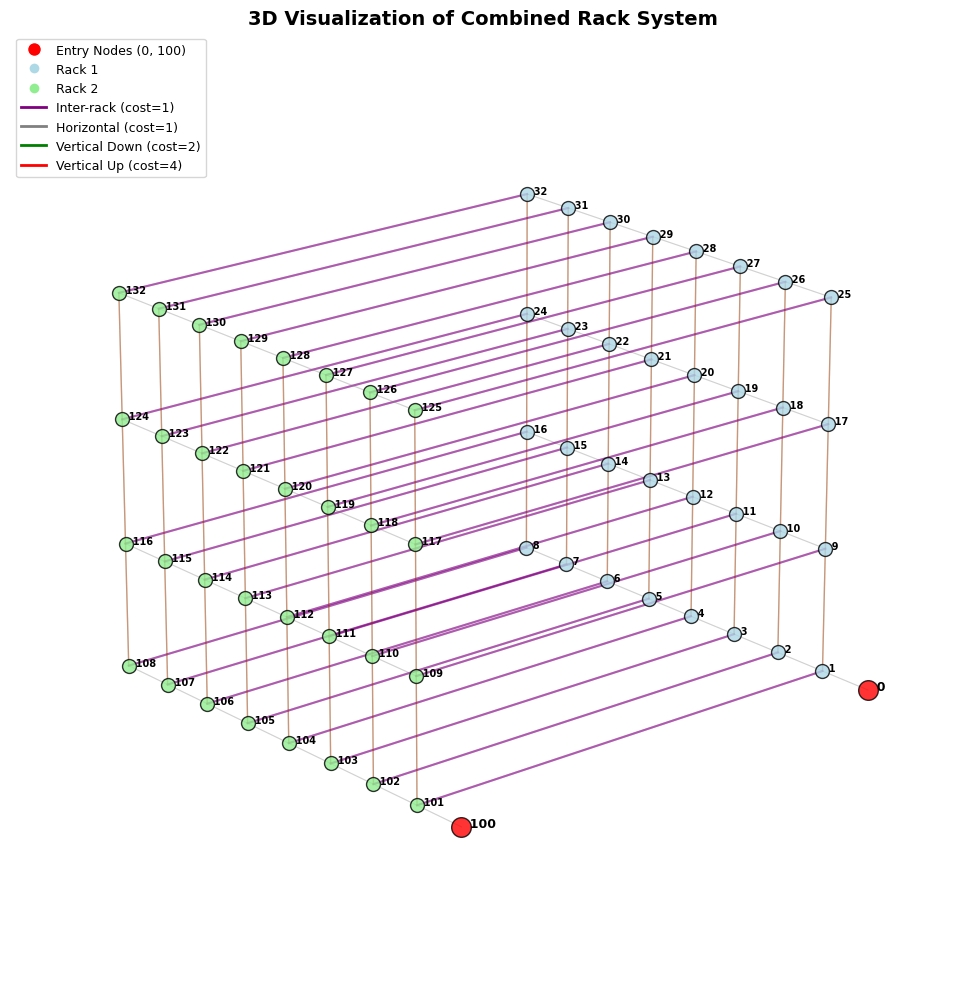

Generating 2D visualization of Rack 1...


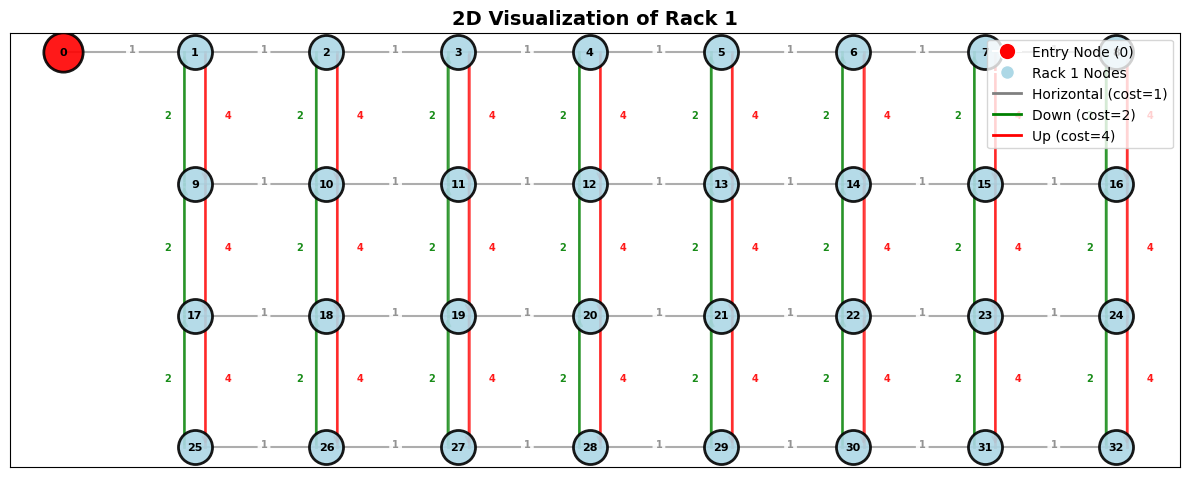

Generating 2D visualization of Rack 2...


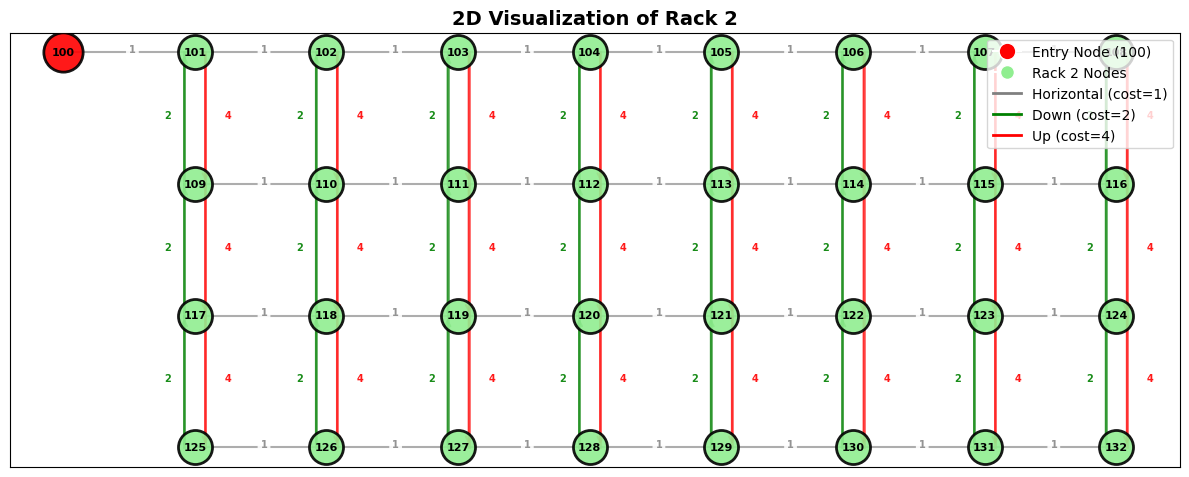

All visualizations generated successfully!


In [26]:
# Generate all visualizations
if __name__ == "__main__":
    # Assuming G_combined exists from your previous code
    # If not, you need to run the rack creation code first
    
    print("Generating 3D visualization of combined system...")
    fig_3d = visualize_3d_combined(G_combined)
    plt.savefig('rack_3d_combined.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Generating 2D visualization of Rack 1...")
    rack1_nodes = list(range(1, 33))
    G_rack1_view = G_combined.subgraph([0] + rack1_nodes)
    fig_rack1 = visualize_2d_rack(G_rack1_view, 1, rack1_nodes)
    plt.savefig('rack_2d_rack1.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Generating 2D visualization of Rack 2...")
    rack2_nodes = list(range(101, 133))
    G_rack2_view = G_combined.subgraph([100] + rack2_nodes)
    fig_rack2 = visualize_2d_rack(G_rack2_view, 2, rack2_nodes)
    plt.savefig('rack_2d_rack2.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("All visualizations generated successfully!") 

## Energy Calculation

### Parameters
<table style="float: left;">
    <thead>
        <tr>
            <th>Parameter</th>
            <th>Values</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>W</td>
            <td>20N</td>
        </tr>
        <tr>
            <td>n</td>
            <td>4</td>
        </tr>
        <tr>
            <td>$ \rho $</td>
            <td><font color ='Yellow'>need to define</font></td>
        </tr>
        <tr>
            <td>A</td>
            <td>$ 0.214 m^{2} $</td>
        </tr>
        <tr>
            <td>$ C_{T} $</td>
            <td>0.001195</td>
        </tr>
        <tr>
            <td>$ \delta $</td>
            <td>0.011</td>
        </tr>
        <tr>
            <td>$ s $</td>
            <td>0.045</td>
        </tr>
        <tr>
            <td>$ k_{0} $</td>
            <td>$ 0.11 $</td>
        </tr>
        <tr>
            <td>$ v_{0} $</td>
            <td>6.325</td>
        </tr>
        <tr>
            <td>$ S_{FP||} $</td>
            <td>$ 0.009 m^{2} $</td>
        </tr>
    </tbody>  
</table>

In [ ]:
#fixed Variables
w = 20
n = 4
A = 0.214
ct = 0.001195
delta=0.011
s=0.045
k=0.11
v0=6.325
sfp_h=0.009
sfp_v=0.377

#variying
rho = 1.168
vh = 5
va = 2
vd = 2

### Hovering

Power consumption for <font color='yellow'>Hovering</font>:

$P_{mh} = P_{bl} + P_{in}$

$P_{bl} = \frac{W^{3/2}}{\sqrt{n\rho A}} C_{T} ^{-3/2} \frac{\delta}{8}s$

$P_{in} = (1+k) \frac{W^{3/2}}{\sqrt{ 2 n\rho A}}$

In [ ]:
p_bl = ((w ** (3/2))/(math.sqrt(n* rho * A)))*(ct**(-3/2))*(delta/8)*s
p_in = (1+k)*((w ** (3/2))/(math.sqrt(2 * n* rho * A)))
p_mh = p_bl + p_in

print("Blade profile power (W) : ", p_bl)
print("Induced power (W) : ", p_in)
print("Hovering power (w) : ", p_mh)

### Forward Fight

Power consumption for <font color='yellow'>Forward flight</font>:

$P_{mf}(V) = P_{bl} + \frac{3}{8} \delta \sqrt{\frac{W n \rho A}{C_{T}}}s V^{2} + P_{in} \left ( \sqrt{ 1 + \frac {V^4}{4v_{0}^{4}}} -  \frac{v^{2}}{2v_{0}^{2}}\right) ^{1/2} + \frac{n}{2} S_{FP||} \rho V^{3}$ 

In [ ]:
p_mf = p_bl + (3/8)*delta*math.sqrt((w * n * rho * A)/ (ct))*s*(vh**2) + p_in*math.sqrt(math.sqrt(1 + (vh**4)/(4*v0**4))-((vh**2)/(2*(v0**2))))+ (n/2*sfp_h*rho*(vh**3))
print("Horizontal power (W) :", p_mf)
print("Horizontal speed(ms-1) : ", vh)

### Vertical Flight

Power consumption for  <font color='yellow'>Accending flight :</font>

$P_{ma}(V) =  P_{mh} + \frac{1}{2} W V +\frac{n}{4} S_{FP \bot} \rho V^{3} + \left( \frac{W}{2} + \frac{n}{4} S_{FP \bot} \rho V^{2}  \right) \sqrt{\left( 1 + \frac{S_{FP \bot}}{A} \right) V^{2} + \frac{2W}{n \rho A}}$

In [ ]:
p_ma = p_mh + (w*va/2) + n/4*sfp_v*rho*(va**3) + (w/2+n/4*sfp_v*rho*(va**2))*math.sqrt((1+sfp_v/A)*(va**2)+(2*w/n*rho*A))

print("Accending Power Consumption (W) : ", p_ma)
print("Accending speed(ms-1) : ", va)

Power consumption for  <font color='yellow'>Decending flight :</font>

$P_{ma}(V) =  P_{mh} + \frac{1}{2} W V -\frac{n}{4} S_{FP \bot} \rho V^{3} + \left( \frac{W}{2} - \frac{n}{4} S_{FP \bot} \rho V^{2}  \right) \sqrt{\left( 1 - \frac{S_{FP \bot}}{A} \right) V^{2} + \frac{2W}{n \rho A}}$

In [ ]:
p_md = p_mh + (w*va/2) - n/4*sfp_v*rho*(va**3) + (w/2 - n/4*sfp_v*rho*(va**2))*math.sqrt((1-sfp_v/A)*(va**2)+(2*w/n*rho*A))

print("Accending Power Consumption (W) : ", p_md)
print("Accending speed(ms-1) : ", vd)

In [ ]:
print(sfp_v/A)